In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from field import lin_interp, linear_ma

ModuleNotFoundError: No module named 'field'

In [90]:
def central_difference(
        field : jnp.ndarray,
        axis : int, 
        delta : float) -> jnp.ndarray:
    
    field_r = jnp.roll(field, 1, axis=axis)
    field_l = jnp.roll(field, -1, axis=axis)
    return (field_r - 2 * field + field_l) / (delta ** 2)

In [91]:
def gradient(
        field : jnp.ndarray,
        delta : float) -> jnp.ndarray:
    
    grad_x = central_difference(field, 0, delta)
    grad_y = central_difference(field, 1, delta)
    grad_z = central_difference(field, 2, delta)

    return jnp.stack([grad_x, grad_y, grad_z], axis=0)

In [92]:
def linear_interp(pos : jnp.ndarray, grid : jnp.ndarray, dx : float) -> jnp.ndarray:

    coords = jnp.linspace(start=0, stop=1, num=grid.shape[0])

    # find position on the grid
    x_idx = jnp.digitize(pos[0] % 1.0, coords, right=True) - 1
    y_idx = jnp.digitize(pos[1] % 1.0, coords, right=True) - 1
    z_idx = jnp.digitize(pos[2] % 1.0, coords, right=True) - 1

    # find the weights
    x_w = (pos[0] % 1.0 - coords[x_idx]) / dx
    y_w = (pos[1] % 1.0 - coords[y_idx]) / dx
    z_w = (pos[2] % 1.0 - coords[z_idx]) / dx

    # perform the interpolation
    interp = grid[x_idx, y_idx, z_idx] * (1 - x_w) * (1 - y_w) * (1 - z_w) + \
             grid[x_idx + 1, y_idx, z_idx] * x_w * (1 - y_w) * (1 - z_w) + \
             grid[x_idx, y_idx + 1, z_idx] * (1 - x_w) * y_w * (1 - z_w) + \
             grid[x_idx + 1, y_idx + 1, z_idx] * x_w * y_w * (1 - z_w) + \
             grid[x_idx, y_idx, z_idx + 1] * (1 - x_w) * (1 - y_w) * z_w + \
             grid[x_idx + 1, y_idx, z_idx + 1] * x_w * (1 - y_w) * z_w + \
             grid[x_idx, y_idx + 1, z_idx + 1] * (1 - x_w) * y_w * z_w + \
             grid[x_idx + 1, y_idx + 1, z_idx + 1] * x_w * y_w * z_w

    return interp

In [132]:
# @jax.jit
def step(
        params,
        grid_star : jnp.ndarray,
        dx : float,
        rate : float):
        
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
        
    grid = linear_ma(pos, weight, grid_size, dx)

    # define the desired change 
    field = (grid - grid_star)

    print(field)

    # get the gradient grid
    grad_field = gradient(field, dx)

    grad_pos_x = linear_interp(
        pos, 
        grad_field[0], 
        dx)
    
    grad_pos_y = linear_interp(
        pos, 
        grad_field[1], 
        dx)
    
    grad_pos_z = linear_interp(
        pos, 
        grad_field[2], 
        dx)
    
    grad_pos = jnp.stack([
        grad_pos_x, grad_pos_y, grad_pos_z])

    params["pos"] = pos + rate * grad_pos

    return params


In [133]:
def mse(params, grid_star : jnp.ndarray):
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
        
    grid = linear_ma(pos, weight, grid_size, dx)

    return jnp.mean((grid_star - grid)**2)
        
def optimize(
        params, 
        grid_star : jnp.ndarray, 
        dx : float, 
        n_steps : int,
        rate : float) -> jnp.ndarray:
    
    for i in range(n_steps):
        params = step(params, grid_star, dx, rate)
        print(f"mse : {mse(params, grid_star)}")

    return params


In [134]:
N = 10000
grid_size = 16
dx = 1

key = jax.random.key(0)

key_pos, key_weight = jax.random.split(key)

# create particles
pos = jax.random.uniform(key_pos, (3, N))
weight = jax.random.uniform(key_weight, (N,)) / N * (grid_size ** 3)

# assign particles 
grid_star = linear_ma(pos, weight, grid_size, dx)

# no matter what N or grid_size is -> ~0.5
print(jnp.mean(grid_star))

0.49868786


In [135]:
key = jax.random.key(1)

key_pos, key_weight = jax.random.split(key)

pos = jax.random.uniform(key_pos, (3, N)) 
weight = jax.random.uniform(key_weight, (N, )) / N * (grid_size ** 3)


params_init = {
    'pos' : pos,
    'weight' : weight}

params = optimize(params_init, grid_star, dx, 100, 0.01)

[[[-0.0139146   0.24228111 -0.15717286 ...  0.59117377 -0.03261608
   -0.5287887 ]
  [ 0.5565079  -0.07860947  0.4981988  ... -0.6003601  -0.36187613
   -0.71557635]
  [-0.25650972 -0.30201697  1.2312976  ...  0.06717852 -0.20282027
    0.83494174]
  ...
  [ 0.5337199  -0.0565421   0.49042103 ... -0.8794464   0.30990314
    0.22649932]
  [ 0.37280393 -0.9991131  -0.20438677 ... -0.60171175 -0.7371867
   -0.6075707 ]
  [-0.12509653 -0.35710874  0.1718049  ...  0.20821309 -0.8793416
    0.5296432 ]]

 [[-0.4409297   0.97531986 -1.1314481  ...  0.24901932  0.41560686
   -0.35316196]
  [ 0.4830917  -0.09843424  0.17325968 ... -0.37584302  0.30223
    0.27012548]
  [-0.27011874  0.64197844  0.         ...  0.02904585 -0.5963177
   -0.7774067 ]
  ...
  [ 0.585134   -0.57152116  0.44757664 ...  0.08458787 -0.5678065
   -1.3077892 ]
  [ 0.03462711  0.2727963  -0.22548033 ... -0.11744738 -0.6605702
   -0.01265398]
  [ 0.41869864 -0.08111179 -0.26456502 ... -1.0660841   0.71167004
   -0.17753327

[[0.52159894 0.23111956 0.4631166  ... 0.14018734 0.98368263 0.15551189]
 [0.39935145 0.37809187 0.60679585 ... 0.95723087 0.01401526 0.07602712]
 [0.6114096  1.0038086  0.00442322 ... 0.9883485  0.33808735 0.09431705]]


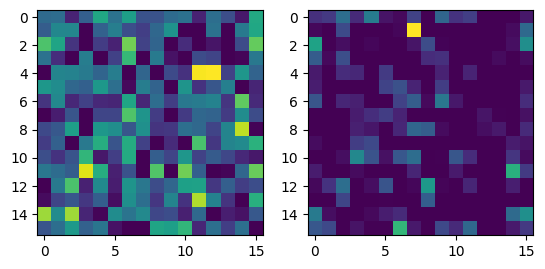

In [123]:

print(params["pos"])

grid = linear_ma(params["pos"], params["weight"], grid_size, 0.1)

# plot side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(grid_star[grid_size // 2, :, :])
plt.subplot(1, 2, 2)
plt.imshow(grid[grid_size // 2, :, :])
plt.show()